## Crop/select aera and calculate cloud fraction should be done in the same period.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
import datetime
from netCDF4 import Dataset # used for the netcdf files which contain lat, lon.
import seaborn as sns

In [2]:
path = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/'
path_era = '//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/'

In [3]:
#path = '/home/hanna/Desktop/master_thesis/meteosat0/'
#era_path = '/home/hanna/Desktop/master_thesis/era/'
grb_files = glob.glob(path+"*.grb")
era = glob.glob(path_era+"*q.nc")

In [4]:
era

['//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/gridarea_q.nc']

In [5]:
len(grb_files)

16474

In [6]:
grb_file = grb_files[0]

In [7]:
era_file = era[0]

In [8]:
era_file

'//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/gridarea_q.nc'

In [9]:
grb_file

'//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/MSG3-SEVI-MSGCLMK-0100-0100-20131013120000X20131013121500.000000000Z-20131013122758-1340656.grb'

In [10]:
def timestamp(filename):
    """
    Returns the np.datetime64 [ns] for the current date.
    """
    splits = filename.split('-')
    print(splits)
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

## Retrieving coordinates from nc file. 
### Notes a nc is 10 times as large as a grib file that is why we only have one of them

In [11]:
import os

In [13]:
nc_path = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'

In [14]:
nc_files = glob.glob(nc_path + '*.nc')

In [15]:
nc_file = nc_files[0]

In [16]:
data = xr.open_dataset(grb_file, engine="pynio")

In [17]:
era = xr.open_dataset(era_file)

In [18]:
era.cell_area.values

array([[1.80000805e+09, 1.80000805e+09, 1.80000805e+09, ...,
        1.80000805e+09, 1.80000805e+09, 1.80000805e+09],
       [1.88778663e+09, 1.88778663e+09, 1.88778663e+09, ...,
        1.88778663e+09, 1.88778663e+09, 1.88778663e+09],
       [1.97524183e+09, 1.97524183e+09, 1.97524183e+09, ...,
        1.97524183e+09, 1.97524183e+09, 1.97524183e+09],
       ...,
       [5.93002167e+09, 5.93002167e+09, 5.93002167e+09, ...,
        5.93002167e+09, 5.93002167e+09, 5.93002167e+09],
       [5.97708317e+09, 5.97708317e+09, 5.97708317e+09, ...,
        5.97708317e+09, 5.97708317e+09, 5.97708317e+09],
       [6.02312052e+09, 6.02312052e+09, 6.02312052e+09, ...,
        6.02312052e+09, 6.02312052e+09, 6.02312052e+09]])

In [19]:
ts = timestamp(grb_file)
data['time'] = ts

['//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/MSG3', 'SEVI', 'MSGCLMK', '0100', '0100', '20131013120000X20131013121500.000000000Z', '20131013122758', '1340656.grb']


In [20]:
# Add time as a coordinate and dimension. 
data = data.assign_coords(time = data.time)

In [21]:
data['CLOUDM_P30_GSV0_I207'].values

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

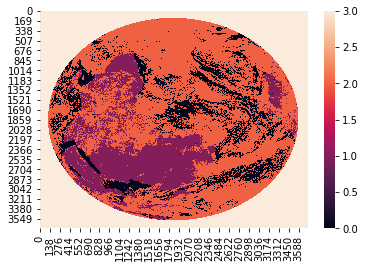

In [22]:
sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)

In [23]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [24]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)
    data = data.expand_dims(dim = 'time')
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={'xgrid_0': 'longitude', 
                                  'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # data = data.sel(latitude = slice(30,60))
    # data = data.sel(longitude = slice(-15, 42))

    tcc, counting = calc_all(data.tcc.values)
    
    data['tcc'].values = tcc
    data['xgrid_0'] = np.arange(-15, 42+0.75, 0.75)
    data['ygrid_0'] = np.arange(30, 60+0.75, 0.75)
    
    return data

In [25]:
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask_array = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan 
lon_array[lon_array < -99] = np.nan

# Compute the d phi and theta

In [26]:
d_theta = (lat_array[:, 1:].transpose() - lat_array[:, :-1].transpose() ).transpose() # pad with zeros
d_phi = lon_array[1:] - lon_array[:-1]
pad = np.ones((1, 3712))*np.nan
d_phi = np.concatenate((pad, d_phi), axis = 0)/2
d_theta = np.concatenate((pad.transpose(), d_theta), axis = 1)/2

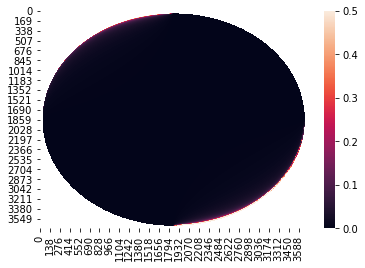

In [27]:
sns.heatmap(d_phi, vmin = 0.0, vmax = 0.5)
plt.show()

In [28]:
np.nanmin(np.abs(d_phi)), np.nanmax(d_phi)

(0.0, 2.6407432556152344)

In [29]:
def area_grid_cell(c_lon, c_lat, d_lat, d_lon):
    """
    c_lon, c_lat : float
        Centre point longitude, latitude in degrees
    d_lat, d_lon : float
        delta lat lon in degrees
        
    returns 
    
    area in km^2
    """   
    R = 6371  # in km
    area = R**2*( np.sin( (c_lat + d_lat)*np.pi/180 ) - np.sin( (c_lat - d_lat)*np.pi/180 )*(d_lon*np.pi/180 ) )
    return area

In [30]:
area = area_grid_cell(lon_array, lat_array, d_theta, d_phi)

In [31]:
ex = area_grid_cell(75, 42, 0.75, 0.75)

In [32]:
ex

27201956.826938473

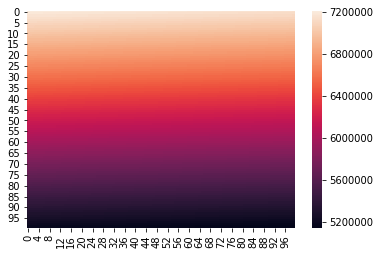

In [33]:
for_plotting = np.abs(area[1500:1600, 500:600])
ax = sns.heatmap(data = for_plotting)#
plt.show()

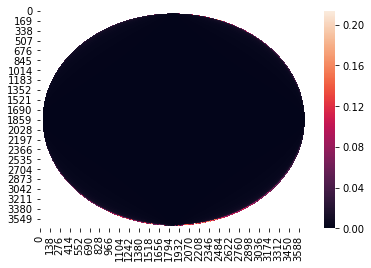

In [34]:
for_plotting = np.abs(d_theta)
ax = sns.heatmap(data = for_plotting)#
plt.show()

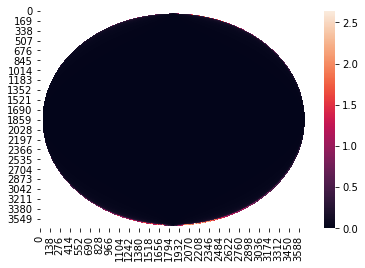

In [35]:
for_plotting = np.abs(d_phi)
ax = sns.heatmap(data = for_plotting)#
plt.show()

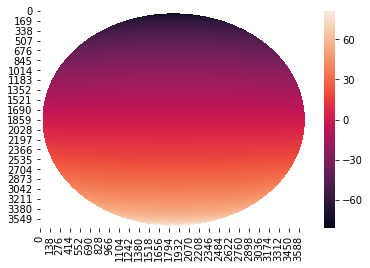

In [176]:
for_plotting = np.abs(lat_array)
ax = sns.heatmap(data = lat_array)#
plt.show()

In [ ]:
for_plotting = np.abs(lon_array)
ax = sns.heatmap(data = lon_array)#
plt.show()

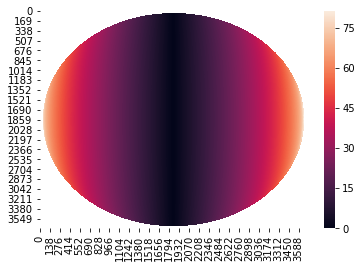

In [38]:
for_plotting = np.abs(lat_array.transpose())
ax = sns.heatmap(data = for_plotting)#
plt.show()

# Comparing to ERA cdo gridarea calculated area 

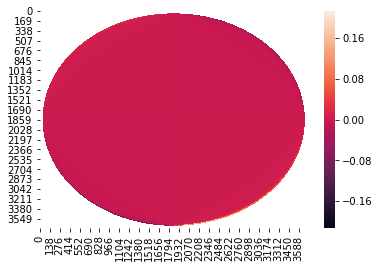

In [186]:
ax = sns.heatmap(data = d_theta)
plt.show()

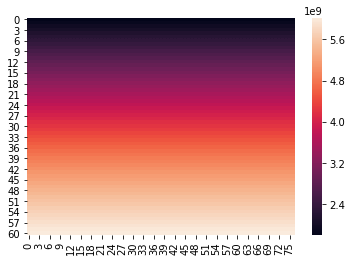

In [40]:
true = era.cell_area.values
ax = sns.heatmap(data = true)#
plt.show()

In [41]:
def area_grid_cell(c_lat, d_lat, d_lon):
    """
    c_lon, c_lat : float
        Centre point longitude, latitude in degrees
    d_lat, d_lon : float
        delta lat lon in degrees
        
    returns 
    
    area in km^2
    """   
    R = 6371000  # in km
    # When comparing : cdo gridarea gridarea: 'Writes the grid cell area to the output stream. 
    # If the grid cell area have to be computed it is scaled with the earth radius to square meters.'
    area = R**2*( np.sin( (c_lat + d_lat/2)*np.pi/180 ) - np.sin( (c_lat - d_lat/2)*np.pi/180 ) )*(d_lon*np.pi/180 ) 
    return area/R

In [42]:
era.latitude.values

array([75.  , 74.25, 73.5 , 72.75, 72.  , 71.25, 70.5 , 69.75, 69.  ,
       68.25, 67.5 , 66.75, 66.  , 65.25, 64.5 , 63.75, 63.  , 62.25,
       61.5 , 60.75, 60.  , 59.25, 58.5 , 57.75, 57.  , 56.25, 55.5 ,
       54.75, 54.  , 53.25, 52.5 , 51.75, 51.  , 50.25, 49.5 , 48.75,
       48.  , 47.25, 46.5 , 45.75, 45.  , 44.25, 43.5 , 42.75, 42.  ,
       41.25, 40.5 , 39.75, 39.  , 38.25, 37.5 , 36.75, 36.  , 35.25,
       34.5 , 33.75, 33.  , 32.25, 31.5 , 30.75, 30.  ], dtype=float32)

In [43]:
calc = area_grid_cell(era.latitude.values, 0.75, 0.75)

In [44]:
calc

array([282.54030483, 296.31439323, 310.04374443, 323.71841682,
       337.3384104 , 350.89875437, 364.39944874, 377.8355227 ,
       391.21194706, 404.5138094 , 417.75602214, 430.91870207,
       444.01179079, 457.03031751, 469.96931141, 482.8188309 ,
       495.59875919, 508.28921306, 520.88522173, 533.40169758,
       545.81875742, 558.15628446, 570.38445388, 582.51320729,
       594.55745709, 606.48240767, 618.31291305, 630.03903161,
       641.65579256, 653.1582251 , 664.55130002, 675.83501733,
       686.98949383, 698.04455431, 708.96540318, 719.77192364,
       730.45417408, 741.01215451, 751.44089412, 761.73542211,
       771.9106509 , 781.94669726, 791.85350281, 801.62112595,
       811.24956667, 820.74379577, 830.09387166, 839.30476513,
       848.36653458, 857.28912162, 866.05761384, 874.68692364,
       883.15716782, 891.48822959, 899.65028414, 907.67315627,
       915.53199198, 923.23176208, 930.78240816, 938.16404701,
       945.39407645])

In [45]:
true[:,0]/6371000

array([282.53147794, 296.30931305, 310.03638885, 323.71035369,
       337.32886501, 350.88958973, 364.39020464, 377.82839683,
       391.20186405, 404.50831512, 417.74547032, 430.91106178,
       444.00283389, 457.01854363, 469.95596102, 482.81286946,
       495.58706611, 508.27636229, 520.87858384, 533.3915715 ,
       545.81318128, 558.14128479, 570.37376968, 582.50853993,
       594.54351626, 606.47663644, 618.30585568, 630.02914698,
       641.64450144, 653.14992867, 664.54345704, 675.82313412,
       686.98702694, 698.03322234, 708.95982732, 719.76496935,
       730.44679667, 741.00347866, 751.43320611, 761.73419152,
       771.90466947, 781.94289685, 791.84715323, 801.61574107,
       811.24698611, 820.73923756, 830.09086848, 839.30027597,
       848.36588151, 857.2861312 , 866.05949603, 874.68447216,
       883.15958115, 891.48337024, 899.6544126 , 907.67130755,
       915.53268082, 923.23718478, 930.78349869, 938.17032889,
       945.39640907])

In [46]:
true[:,0]-true[:,1]

array([-6.67572021e-06, -8.10623169e-06, -6.19888306e-06, -4.76837158e-07,
        9.05990601e-06,  2.86102295e-06,  4.76837158e-07, -5.72204590e-06,
       -1.09672546e-05,  4.76837158e-06,  1.19209290e-05, -7.15255737e-06,
       -2.28881836e-05, -3.33786011e-06, -4.29153442e-06, -1.14440918e-05,
       -4.76837158e-06, -4.29153442e-06,  0.00000000e+00,  2.76565552e-05,
        4.76837158e-07, -9.53674316e-07, -1.04904175e-05, -1.71661377e-05,
       -2.19345093e-05, -3.33786011e-06, -4.76837158e-07,  1.43051147e-06,
        1.09672546e-05, -6.19888306e-06, -1.43051147e-06, -5.72204590e-06,
       -2.86102295e-06, -9.53674316e-07,  2.09808350e-05,  1.33514404e-05,
        1.71661377e-05,  2.47955322e-05, -1.23977661e-05, -1.14440918e-05,
       -5.72204590e-06, -8.58306885e-06,  8.58306885e-06, -3.52859497e-05,
       -2.86102295e-05, -2.86102295e-06, -9.53674316e-07, -4.76837158e-06,
        2.95639038e-05,  1.52587891e-05,  1.90734863e-05,  1.43051147e-05,
       -6.67572021e-06, -

In [48]:
#for_plotting = np.abs(calc)
#ax = sns.heatmap(calc)#
#plt.show()

In [100]:
0.75/2

0.375

In [115]:
phi_range    = (-15 - 0.75/2, -15 +0.75/2)
theta_range = (30-.75/2,  30+.75/2)

In [116]:
phi_range, theta_range

((-15.375, -14.625), (29.625, 30.375))

In [117]:
c_lon = lon_array.reshape(-1) #+ d_phi
c_lat = lat_array.reshape(-1) #+ d_theta

In [118]:
l, u = phi_range
low   = np.argwhere(c_lon > l) 
upper = np.argwhere(c_lon < u)
idx_phi = np.intersect1d(low, upper)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
l, u  = thetha_range
low   = np.argwhere(c_lat > l) 
upper = np.argwhere(c_lat < u)
idx_theta = np.intersect1d(low, upper)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


# Final intersect now contains the idx og the flatted array which hould be used in order to calc cloud fraction in one cell. 
## Now need to find the boundary boxes.

In [120]:
final_intersect = np.intersect1d(idx_phi, idx_theta)

In [121]:
len(final_intersect)

490

In [183]:
lons = lon_array.reshape(-1)[final_intersect] + d_phi.reshape(-1)[final_intersect]
lats = lat_array.reshape(-1)[final_intersect]# + d_theta.reshape(-1)[final_intersect]

# LAT, LONS min max should be out of range of their respective ranges
## Someting wrong with lat ranges since their not --> compute the rest the redo calculations of d_phi and d_theta.

In [123]:
lons.min(), lons.max(), phi_range

(-15.37669849395752, -14.629000663757324, (-15.375, -14.625))

In [124]:
lats.min(), lats.max(), theta_range

(29.6329402923584, 30.367465019226074, (29.625, 30.375))

In [134]:
def area_grid_cell(c_lat, d_lat, d_lon):
    R = 6371000  # in m 
    # When comparing : cdo gridarea gridarea: 'Writes the grid cell area to the output stream. 
    # If the grid cell area have to be computed it is scaled with the earth radius to square meters.'
    area = R**2*( np.sin( (c_lat + d_lat)*np.pi/180 ) - np.sin( (c_lat - d_lat)*np.pi/180 ) )*(d_lon*np.pi/180 ) 
    return area

In [138]:
area_entire_cell = area_grid_cell(lats, d_theta.reshape(-1)[final_intersect], 2*d_phi.reshape(-1)[final_intersect])

### Recompute centre of cells and new area 


In [165]:
c_era_lon = -15
c_era_lat = 30
d_era = 0.75/2

# + d_phi.reshape(-1)[final_intersect]
c_mlons = lon_array.reshape(-1)[final_intersect][0]
d_lon   = d_phi.reshape(-1)[final_intersect][0]

c_mlats = lat_array.reshape(-1)[final_intersect][0]
d_lat   = d_theta.reshape(-1)[final_intersect][0]

In [185]:
a = d_theta.reshape(-1)[final_intersect]
len(a[a<0]), len(a)

(490, 490)

In [175]:
len(d_theta[d_theta>0])

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


5134586

In [174]:
len(d_theta[d_theta<0])

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


5134586

In [166]:
d_lat

-0.000457763671875

In [167]:
c_mlons, c_mlats

(-15.366567, 29.652994)

In [168]:
dx = (c_mlons - d_lon - c_era_lon - d_era)/2
dy = (c_mlats - d_lat - c_era_lat + d_era)/2

In [169]:
c_mlats, d_lat, c_era_lat, d_era

(29.652994, -0.000457763671875, 30, 0.375)

In [163]:
dy

0.01552891731262207

In [156]:
c_mlons, d_lon, c_era_lon, d_era

(-15.366567, -0.003063678741455078, -15, 0.375)

In [158]:
c_mlons + d_lon

-15.369630336761475

In [157]:
dx

-0.7385029792785645

###  DELETE BELOW 

In [125]:
lat_nc = rootgrp.variables["lat"][:].data
lon_nc = rootgrp.variables["lon"][:].data

In [126]:
lon = -15
lat = 30

dlon = 0.75/2
dlat = 0.75/2

minLat = lat - dlat
maxLat = lat + dlat

# OBS! Problem with sign when it comes to longitude 
a = lon - dlon
b = lon + dlon
minLon = np.min([a, b])
maxLon = np.max([a, b])

In [127]:
x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
X = np.unique(x_idx)
Y = np.unique(y_idx)

In [128]:
np.mean(lon_nc[X, :][:, Y])

-15.010457

In [129]:
np.mean(lat_nc[X, :][:, Y])

30.000273

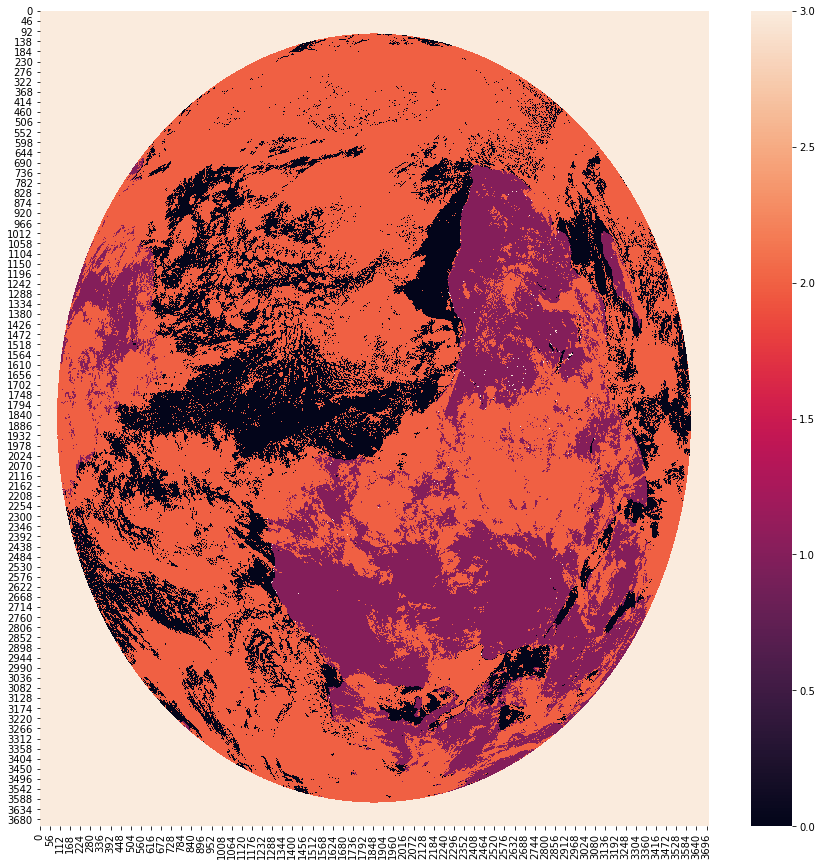

In [130]:
plt.figure(figsize=(15,15))
sns.heatmap(cloud_mask_array)

In [131]:
a = data['CLOUDM_P30_GSV0_I207'].values

In [132]:
a

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

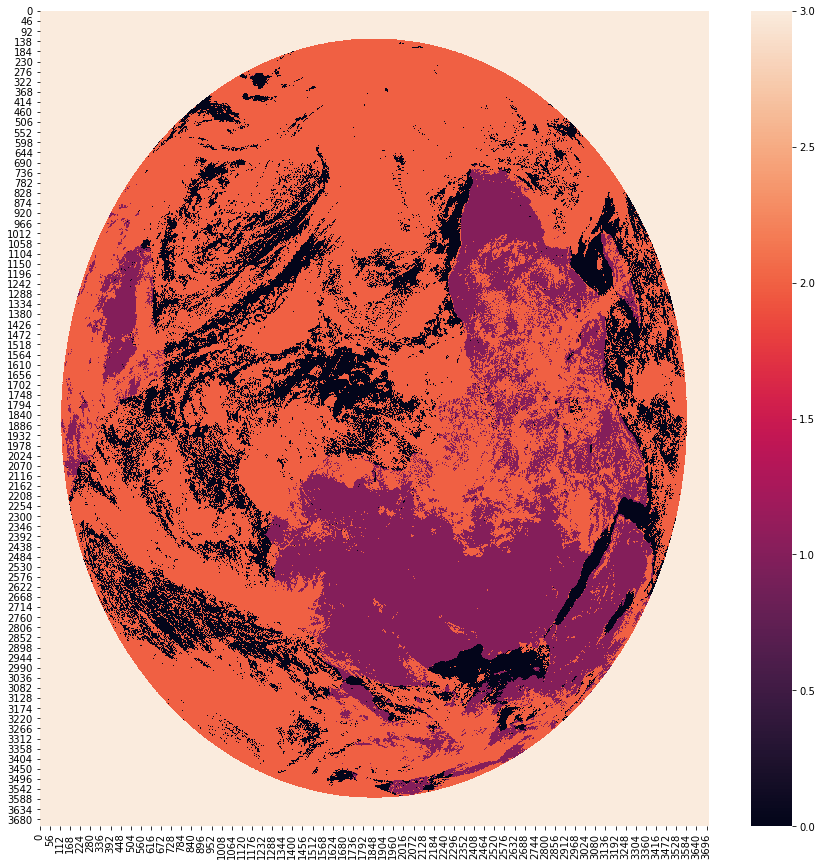

In [133]:
plt.figure(figsize = (15,15) )
sns.heatmap(np.fliplr(a))

In [ ]:
def calc_one_mean(lon, lat, lon_nc, lat_nc, clm_grb):
    """
    lon : float 
        single value of the cell you want to calc mean to.
        
    lat : float
        same as above
    
    lon_nc : 2D array
        array containg all the lons fron the netcdf files.
    
    lat_nc : 2D array
        array containg all the lat fron the netcdf files.
    
    clm_grb : 2Darray 
        data from the grib file.
        
    Notes
    ------------------------------
    The grib file needs too be flipped left and right in order to 
    
    
    """
    
    dlon = 0.75/2
    dlat = 0.75/2
    
    minLat = lat - dlat
    maxLat = lat + dlat
    
    # OBS! Problem with sign when it comes to longitude 
    a = lon - dlon
    b = lon + dlon
    minLon = np.min([a, b])
    maxLon = np.max([a, b])
    
    # Find the index of the cell which correspond to the 
    x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
    X = np.unique(x_idx)
    Y = np.unique(y_idx)
    
    #cloud_flipped = np.fliplr(clm_grb) 
    # need to flip the grib file so its on the same format as netcdf file where we get the coordinates.
    
    # TODO: maybee you need to look at the box around the satelitte image 
    meanLon = np.mean(  lon_nc[X, :][:, Y]    )
    meanLat = np.mean(  lat_nc[X, :][:, Y]   )
    
    
    #todo wich back 
    cloud_flipped = clm_grb
    
    # retrieve cloud mask
    submat = cloud_flipped[X, :][:, Y]
    submat[submat == 3.] = np.nan 
    count_nan = (np.isnan(submat)).sum()
    if count_nan  > 0: # 3 denotes of earth disk. The cloud data can only originate from inside the earth disk
        print("OBS the nr 3. lon: {} lat: {}   || meanlon {} mean lat {}".format(lon, lat, meanLon, meanLat))
    submat[submat == 1] = 0 # no cloud over ocean --> no cloud 
    submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction
    cloud_fraction = np.nanmean(submat)
    _x, _y = submat.shape
    count_cells = int(_x*_y)
    
    return cloud_fraction, count_cells, count_nan

In [ ]:
def calc_one_mean(lon, lat, lon_nc, lat_nc, clm_grb):
    """
    lon : float 
        single value of the cell you want to calc mean to.
        
    lat : float
        same as above
    
    lon_nc : 2D array
        array containg all the lons fron the netcdf files.
    
    lat_nc : 2D array
        array containg all the lat fron the netcdf files.
    
    clm_grb : 2Darray 
        data from the grib file.
        
    Notes
    ------------------------------
    The grib file needs too be flipped left and right in order to 
    
    
    """
    
    dlon = 0.75/2
    dlat = 0.75/2
    
    minLat = lat - dlat
    maxLat = lat + dlat
    
    # OBS! Problem with sign when it comes to longitude 
    a = lon - dlon
    b = lon + dlon
    minLon = np.min([a, b])
    maxLon = np.max([a, b])
    
    # Find the index of the cell which correspond to the 
    x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
    X = np.unique(x_idx)
    Y = np.unique(y_idx)
    
    #cloud_flipped = np.fliplr(clm_grb) 
    # need to flip the grib file so its on the same format as netcdf file where we get the coordinates.
    
    # TODO: maybee you need to look at the box around the satelitte image 
    meanLon = np.mean(  lon_nc[X, :][:, Y]    )
    meanLat = np.mean(  lat_nc[X, :][:, Y]   )
    
    
    #todo wich back 
    cloud_flipped = clm_grb
    
    # retrieve cloud mask
    submat = cloud_flipped[X, :][:, Y]
    submat[submat == 3.] = np.nan 
    count_nan = (np.isnan(submat)).sum()
    if count_nan  > 0: # 3 denotes of earth disk. The cloud data can only originate from inside the earth disk
        print("OBS the nr 3. lon: {} lat: {}   || meanlon {} mean lat {}".format(lon, lat, meanLon, meanLat))
    submat[submat == 1] = 0 # no cloud over ocean --> no cloud 
    submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction
    cloud_fraction = np.nanmean(submat)
    _x, _y = submat.shape
    count_cells = int(_x*_y)
    
    return cloud_fraction, count_cells, count_nan
    
    

In [ ]:
clm, cnt_cells, cnt_nans = calc_all(filename = grb_file)

In [ ]:
clm

In [ ]:
sns.heatmap(cnt_nans)

In [ ]:
sns.heatmap(cnt_cells)

In [ ]:
sns.heatmap(clm)

In [ ]:
sns.distplot(clm.flatten())

In [ ]:
ax = sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)
ax.invert_yaxis()
ax.invert_xaxis()

In [ ]:
ax = sns.heatmap(clm)
#ax.invert_yaxis()

In [ ]:
ax = sns.heatmap(cnt_cells)
ax.invert_yaxis()
ax.set_title("The number of grid cells involved in calculating the cloud fraction from cloud mask.");

In [ ]:
tcc = clm
lon = np.arange(-15, 40+0.75, 0.75)
lat = np.arange(30, 58+0.75, 0.75)

In [ ]:
tcc.shape, lon.shape, lat.shape

In [ ]:
nc_path = '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/'
nc_files = glob.glob(nc_path+"*EUMETSAT*.nc")

In [ ]:
counter = 0
for filename in grb_files:# grb file of satellite image...
    print(filename)
    if counter == 0:
        print("enters 0")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                         'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                        'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                         coords={'longitude': (['longitude'], lon),
                                 'latitude': (['latitude'], lat), 
                                })

        ts = timestamp(filename)
        ds['time'] = ts

        # Add time as a coordinate and dimension. 
        ds = ds.assign_coords(time = data.time)
        ds = ds.expand_dims(dim = 'time')
        counter += 1

    else:
        print("enters 1")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                             'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                             'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                              coords={'longitude': (['longitude'], lon),
                                      'latitude': (['latitude'], lat), 
                                       })

        ts = timestamp(filename)
        new_ds['time'] = ts

        # Add time as a coordinate and dimension. 
        new_ds = new_ds.assign_coords(time = data.time)
        new_ds = new_ds.expand_dims(dim = 'time')

        ds.merge(new_ds)

        counter += 1

print(ds)

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                     'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                     'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                    
                      coords={'longitude': (['longitude'], lon),
                              'latitude': (['latitude'], lat) })

ts = timestamp(filename)
new_ds['time'] = ts

# Add time as a coordinate and dimension. 
new_ds = new_ds.assign_coords(time = data.time)
new_ds = new_ds.expand_dims(dim = 'time')

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds

In [ ]:
def create_grb_file_by_filenames(filenames):
    counter = 0
    for filename in filenames:# grb file of satellite image...
        print()
        if counter == 0:
            print("enters 0")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension. 
            ds = ds.assign_coords(time = data.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1
            
        else:
            print("enters 1")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            new_ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension. 
            new_ds = new_ds.assign_coords(time = data.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            ds.merge(new_ds)
            
            counter += 1
            
    print(ds)
    return 

In [ ]:
import seaborn as sns

In [ ]:
cloud_mask_array = np.flip(rootgrp.variables["cloudMask"][:].data)

In [ ]:
sns.heatmap(cloud_mask_array) # nc with correct coordinates

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
sns.heatmap(a)

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
data['CLOUDM_P30_GSV0_I207'].plot()

In [ ]:
sns.heatmap(a)

In [ ]:
rows = cloud_mask_array[X, :]
submat = rows[:, Y]
submat.shape

In [ ]:
# Todo plot netcdf of se hvordan det ser ut 

## OBS! sjekk om det ceteret i cellen som lat, lon. Hvordan korrigere for dette. 

In [ ]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [ ]:
submat[submat == 1] = 0 # no cloud over ocean --> no cloud 

In [ ]:
submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction

In [ ]:
submat.mean()

In [ ]:
sum(submat == 3)

# Check that the cloud cover only contain 0,1,2 replace all 2
## replace so that its zero and 0 and 1. 
### Maybee you should replace 

In [ ]:
row = lon_array[X,:]
row[:,Y]

## Make a map 

In [ ]:
import cartopy.crs as ccrs

In [ ]:
import cartopy as cp
def plot_map(lat = (30,60), lon = (-30,35), path = "maps/",
    title = "MeteoSat vision Europa", filename = "MeteoSat_vision_Europa.png"):
    """
    Plot map defined by lat lon, default Europe.
    Path should be to lagringshotell, don't save png's on git ...
    """
    plt.figure(figsize = (15,15))
    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.add_feature(cp.feature.OCEAN, zorder=0)
    ax.add_feature(cp.feature.LAND, zorder=0, edgecolor='black')
    ax.coastlines(resolution='50m')
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], ccrs.PlateCarree())

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.)

    ax.text(0.03, 0.07, "MeteoSat vision Europa", transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #plt.savefig(path + filename, bbox_inces = "thight")
    plt.show()

In [ ]:
plot_map()